In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from collections import namedtuple

from scipy.stats import lognorm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.colors as c

In [2]:
import sys, os

In [14]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from episiming.compartimentais import F
import episiming
import episiming.compartimentais as compartimentais

In [4]:
# loc = 0.2
# fator = 3.5
# delta = [-0.7, -0.72, -0.74, -0.76, 0.588998524445772]
# eta = [1.6, 1.8, 2, 2.2, 0.8561692830061872]
beta = 0.6
gamma = 1/2.6
loc = 0.2
fator = 3.5
delta =  3*[np.log(np.log(2)/gamma)]
eta = [np.sqrt(-2*np.log(np.log(2))), 0.65, 1.05]
kappa0 = lambda t: fator*lognorm.pdf(t, s=np.exp(delta[0]), scale=eta[0], loc=loc)
kappa1 = lambda t: fator*lognorm.pdf(t, s=np.exp(delta[1]), scale=eta[1], loc=loc)
kappa2 = lambda t: fator*lognorm.pdf(t, s=np.exp(delta[2]), scale=eta[2], loc=loc)
# kappa3 = lambda t: fator*lognorm.pdf(t, s=np.exp(delta[3]), scale=eta[3], loc=loc)
# kappa4 = lambda t: fator*lognorm.pdf(t, s=np.exp(delta[4]), scale=eta[4], loc=loc)
# kappas = [ kappa0, kappa1, kappa2, kappa3, kappa4]
kappas = [kappa0, kappa1, kappa2]

In [5]:
t_0 = 0
dt = 1
num_dt = 60
T = t_0 + num_dt*dt
dados_temporais = [t_0, dt, num_dt]
tempos = np.linspace(t_0, num_dt*dt, num_dt+1)
num_sim = 20

In [6]:
rede_completa = episiming.cenarios.RedeCompleta(300, 20, 0.6, 1/2.6, kappa = kappa0)

In [7]:
p = 0.1
lamb = 0.1
beta = 0.7
theta = 0.9
sigma= 0.5
rho = 0.8
gammaA = 0.2
epsA = 0.05
gammaI = 0.1
epsI = 0.2
dI = 0.15
gammaD = 0.15
dD = 0.15

In [8]:
jia = [p, lamb, beta, theta, sigma, rho, gammaA, epsA, gammaI, epsI, dI, gammaD, dD]

In [11]:
X = rede_completa.evolui_matricial(dados_temporais, num_sim, show='sd', jia = jia)

### comparando com o caso compartimental:

In [18]:
I_0 = 20
pop_0 = [280,0,20,0,0,0,0]

def evolucao_SEIRMQDA(pop_0, p, lamb, beta, theta, sigma, rho, gammaA,
                      epsA, gammaI, epsI, dI, gammaD, dD,tempos,
                      plot=False):
    """
    Implementação do modelo SEIRMQDA compartimental.
    """

    SEIRMQDA_Compartimental = namedtuple('SEIRMQDA_Compartimental', 
                                 [
                                     'pop_0',
                                     'num_pop',
                                     'p',
                                     'lamb',
                                     'beta',
                                     'theta',
                                     'sigma',
                                     'rho',
                                     'gammaA',
                                     'epsA',
                                     'gammaI',
                                     'epsI',
                                     'dI',
                                     'gammaD',
                                     'dD',
                                     'tempos',
                                     'S',
                                     'E',
                                     'I', 
                                     'R',
                                     'M',
                                     'Q',
                                     'D',
                                     'A',
                                     'X'
                                 ])        
          
    def diferencial(t, X, N, p, lamb, beta, theta, sigma, rho, gammaA,
                    epsA, gammaI, epsI, dI, gammaD, dD):
        S, E, I, R, M, Q, D, A = X
        dXdt = [- beta*I*S/N -p*S + lamb*Q - theta*A*S/N, 
                beta*I*S/N - sigma*E + theta*A*S/N, 
                sigma*rho*E - gammaI*I - dI*I - epsI*I,
                gammaI*I + gammaA*A, 
                dD*D + dI*I, 
                p*S - lamb*Q, 
                epsI*I + epsA*A - gammaD*D - dD*D ,
                sigma*(1-rho)*E - gammaA*A - epsA*A]
        return dXdt        
    
    num_pop = sum(pop_0)
    y0 = [num_pop-I_0, 0, I_0, 0, 0, 0, 0, 0]
    sol = solve_ivp(diferencial, t_span=[tempos[0],tempos[-1]], 
                    y0 = y0, t_eval = tempos,
                    args=(num_pop, p, lamb, beta, theta, sigma, rho, 
                          gammaA, epsA, gammaI, epsI, dI, gammaD, dD))
    
    resultado = SEIRMQDA_Compartimental(
        pop_0, num_pop, p, lamb, beta, theta, sigma,rho, gammaA, epsA, 
        gammaI, epsI, dI, gammaD, dD, tempos,
        sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], 
        sol.y[5], sol.y[6], sol.y[7], sol)
    return resultado

def F(t, v, beta, theta, p, lamb, sigma, rho, epsA, gammaA, epsI, gammaI, deathI, gammaD, deathD):
    """Differential equation for SEIR-QAD model"""
    # Estado
    # Suscetíveis
    # Em isolamento
    # Expostos
    # Assintomáticos
    # Sintomáticos
    # Assintomáticos diagn
    # Sintomáticos diagn
    # Recuperados
    # Total de casos
    # Total de diagnosticados Assint
    # Total de diagnosticados Sintom
    # Total de óbitos
    
    S,Q,E,A,I,DA,DI,*totals = v
    dS = - beta*S*(I + theta*A) - p*S + lamb*Q
    dQ = p*S - lamb*Q
    dE = beta*S*(I + theta*A) - sigma*E
    dA = sigma*(1 - rho)*E - epsA*A - gammaA*A
    dI = sigma*rho*E - epsI*I - gammaI*I - deathI*I
    dDA = epsA*A - gammaA*DA
    dDI = epsI*I - gammaD*DI - deathD*DI
    # Extra state for auxiliary variables (idx 7-11)
    dR = gammaA*A + gammaI*I + gammaD*DI
    dCt = sigma*E
    dDAt = epsA*A
    dDIt = epsI*I
    dMt = deathD*DI + deathI*I
    return np.array([dS, dQ, dE, dA, dI, dDA, dDI, dR, dCt, dDAt, dDIt, dMt])

In [22]:
X_comp = evolucao_SEIRMQDA(pop_0,*jia, tempos,plot=True)

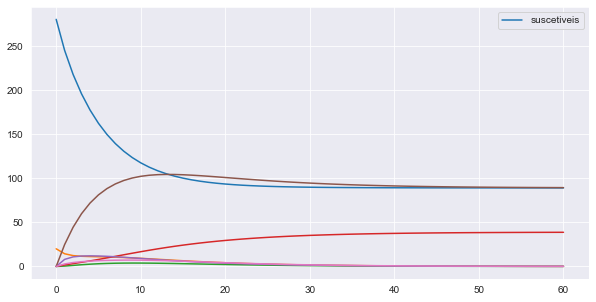

In [25]:
plt.figure(figsize = (10,5))
plt.plot(X_comp.S, label = 'suscetiveis')
plt.plot(X_comp.I)
plt.plot(X_comp.A)
plt.plot(X_comp.R)
plt.plot(X_comp.E)
plt.plot(X_comp.Q)
plt.plot(X_comp.D)
plt.legend()